# **Homework 3_1**

Выполнил: Касенов Султан

В данной работе попытаемся обучить модели, которые будут предсказывать цену жилья для одного датасета. Для начала импортируем все нужные библиотеки.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
import sklearn.compose
import sklearn.tree

import seaborn as sns

Скачаем наш датасет и сразу проверим его на наличие NaN values. 

In [67]:
df = pd.read_csv('http://www.soshnikov.com/temp/data/kc_house_data_processed.zip', compression='zip')

Значение false означает, что нам повезло и таких значений нету. 

In [68]:
df.isna().any().any()

False

Теперь можно рассмотреть датасет и начать его чистку.


In [69]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Data Cleaning

Рассмотрим типы признаков. 

In [70]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Удалим id так как он не является признаком.

In [71]:
df = df.drop('id', axis=1)

Следует отметить, что все значения имеют числовой тип однако признак date является обьектом string. Заменим его на числовое значение. 

In [72]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime("%Y%m%d").astype(int)

Проверяем распределение

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a27d70520>,
      dtype=object)

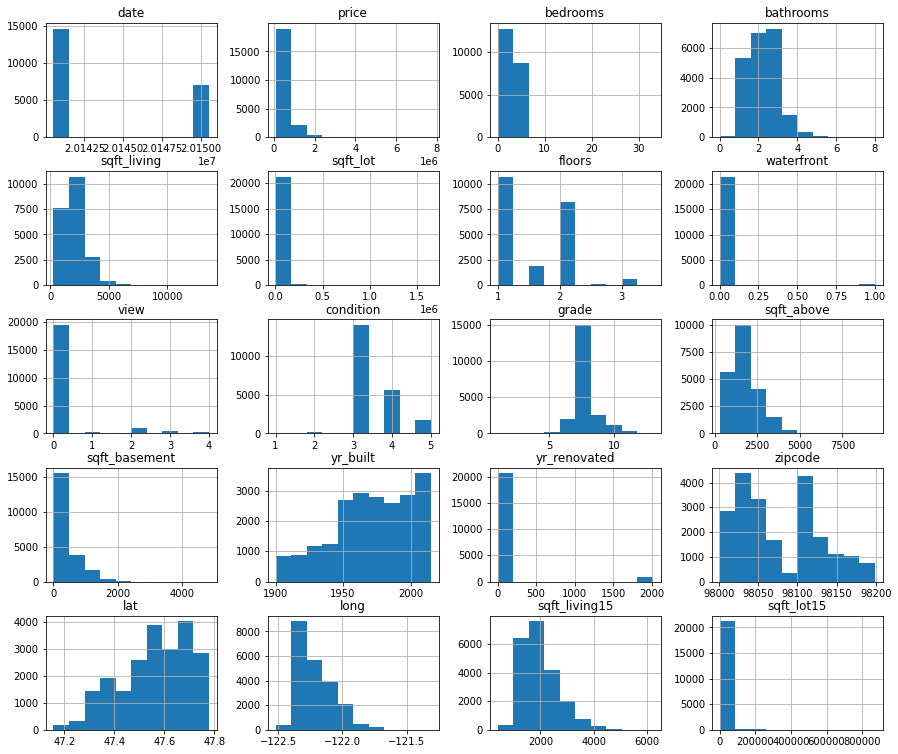

In [73]:
df.hist(figsize=(15,13))

Следует отметить, что цена имеет смещеное распределение и поэтому удобно будет привести его к нормальному используя логарифм. Теперь можно проверить новое распределение.


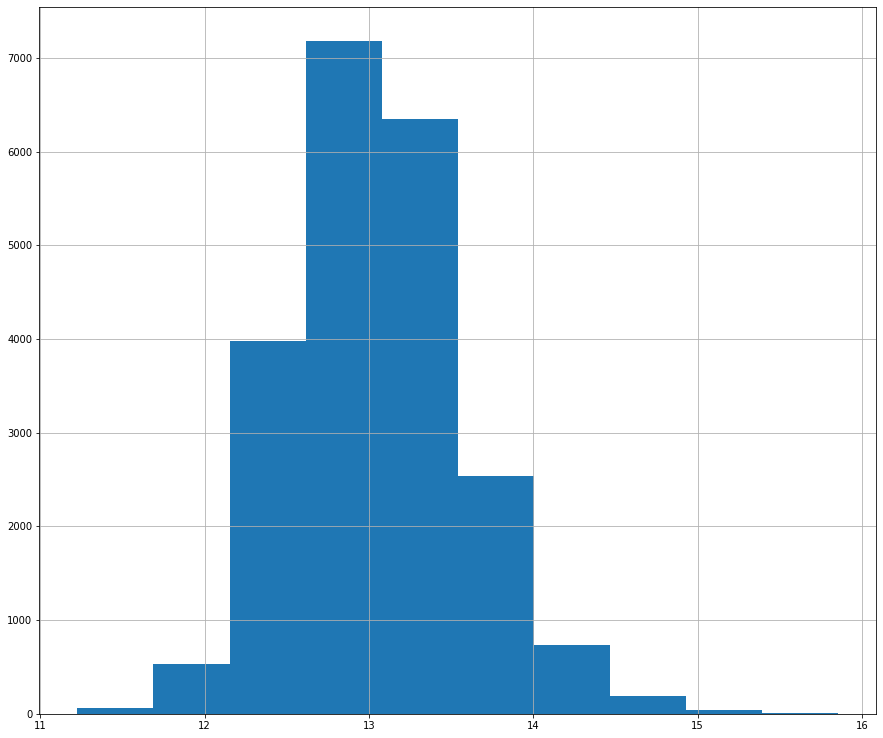

In [74]:
df['log_price'] = np.log(df['price'] + 1)
df['log_price'].hist(figsize=(15,13))

Рассмотрим матрицу корреляции. Некоторые признаки имеют очень низкую корреляцию с ценой, поэтому мы их удалим или попробуем сгенирировать новые признаки. 

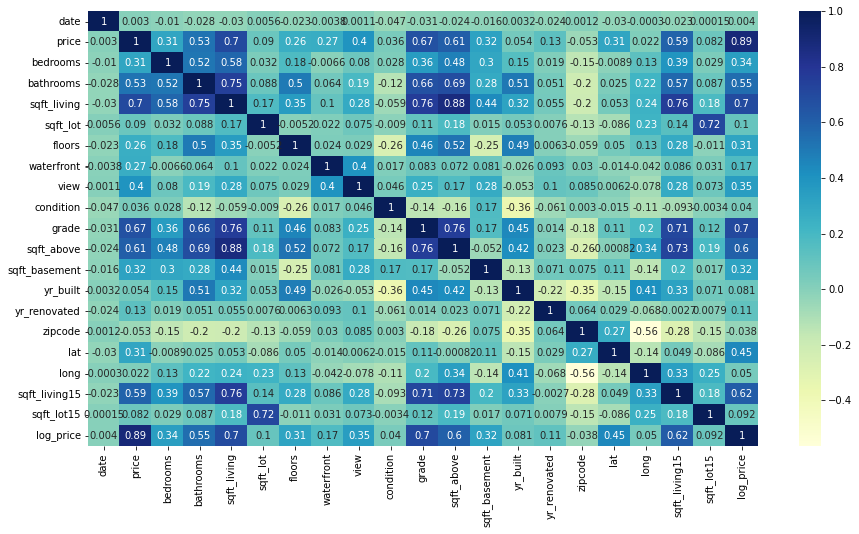

In [75]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

Делим наш датасет на тестовую и обучающую часть

In [76]:
df_train, df_test = sk.model_selection.train_test_split(df, train_size=0.8, shuffle=True)

**Нормализация значений**

Для начала сохраним названия всех признаков в один список и сразу уберем ненужные признаки. 


In [94]:
features = list(df.columns)
features.remove('price')
features.remove('log_price')
features.remove('date')
features.remove('long')
features.remove('condition')
features.remove('zipcode')
features.remove('yr_renovated')
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'sqft_living15',
 'sqft_lot15']

 Встроим нормализацию в наш конвейер предобработки

In [100]:
# подумай насчет minmax или standardscaler()
transformer = sk.compose.make_column_transformer(
    (sk.preprocessing.StandardScaler(), ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'bathrooms']),
    (sk.preprocessing.MinMaxScaler(), [ 'lat', 'bedrooms']),
    (sk.preprocessing.OneHotEncoder(),['yr_built']),
    remainder='passthrough'
)

X = transformer.fit_transform(df_train[features])

Обучаем модель. 

In [103]:
Y = df_train["log_price"]

model = sk.linear_model.LinearRegression()
model.fit(X, Y)





LinearRegression()

Далее тестируем нашу модель и находим MAE значение в процентах.

In [104]:
X_t = transformer.transform(df_test[features])
Y_t = df_test['log_price']

Y_p = model.predict(X_t)

print(sk.metrics.mean_absolute_percentage_error(Y_p, Y_t))


0.01493129571407361


Можно рассмотреть коэфициенты однако интерпретировать их будет сложно. 

In [105]:
model.coef_, model.intercept_

(array([ 0.06283246,  0.01893628,  0.05033691,  0.0364822 ,  0.0708145 ,
        -0.0025457 ,  0.05503764,  0.81375872, -0.02881672,  0.22666574,
         0.25103771,  0.25948039,  0.13570238,  0.22698523,  0.24775937,
         0.23935129,  0.26378451,  0.16534955,  0.24046861,  0.18857132,
         0.25691948,  0.17766454,  0.12866812,  0.18749155,  0.18423223,
         0.19877266,  0.20158548,  0.14431483,  0.23119798,  0.16108023,
         0.1588059 ,  0.16568046,  0.22598637,  0.22693996,  0.22606733,
         0.19596089,  0.19669424,  0.11856555,  0.13433415,  0.10461221,
         0.11483541,  0.06315113,  0.03495491,  0.0171262 ,  0.00342793,
         0.06535652,  0.07388274,  0.07486849,  0.08364473,  0.08447476,
         0.13704374,  0.04002389, -0.0201971 , -0.00997292,  0.10377132,
         0.13374527,  0.00985364, -0.00951362,  0.01265244,  0.02322591,
         0.03319503,  0.05087475,  0.02093431, -0.00958   , -0.02469614,
        -0.03530525, -0.0568609 , -0.01763282, -0.0

Добавим полиномиальные комбинации признаков чтобы немного улучшить точность. 

In [106]:
poly = sk.preprocessing.PolynomialFeatures()
Xp = poly.fit_transform(X)


Чтобы уменьшить количество кода добавим конвеер чтобы заново не описывать шаги. Также запринтим точность нашей модели, которая равна 80 процентам. 

In [ ]:
pipe = sk.pipeline.Pipeline([
    ('ColumnTransform',transformer),
    ('PolyFeatures',poly),
    ('LinearModel',model)
])
pipe.fit(df_train[features], Y)
pipe.score(df_test[features],Y_t)

KeyboardInterrupt: ignored